# Regressione
Introduzione alla regressione in **Scikit-learn**.

Individueremo le combinazioni di iperparametri che permettono di minimizzare l'RMSE (*Root Mean Squared Error*) sul dataset fornito utilizzando *Cross-Validation* e *Grid Search*.

# Descrizione del dataset

L'obiettivo è quello di creare un modello di regressione in grado di prevedere la quantità di energia prodotta da un impianto fotovoltaico. Il dataset è relativo a un impianto fotovoltaico reale di 960 kWP ubicato a Lecce. Il dataset:

- contiene circa 15000 record relativi a medie orarie su un periodo di poco meno di 2 anni (500 giorni);
-  la variabile **indipendente** è costituita dal vettore 6-dimensionale [Ora, Data, Temperatura ambiente, Temperatura dei moduli, Irraggiamento dei pannelli inclinati a 3 gradi, Irraggiamento dei pannelli inclinati a 15 gradi];
-  la **variabile dipendente** (valore *target*) è costituita dalla produzione in kWH dell'impianto in una determinata ora.

Di seguito vengono forniti i riferimenti per ulteriori approfondimenti:
- M. Malvoni, M. G. De Giorgi, P. M. Congedo, [*Data on photovoltaic powerforecasting models for Mediterranean climate*](https://www.sciencedirect.com/science/article/pii/S2352340916302773), Data in Brief, 2016.
- M. G. De Giorgi, M. Malvoni, P. M. Congedo, [*Comparison of strategies for multi-step ahead photovoltaic power forecasting models based on hybrid group method of data handling networks and least square support vector machine*](https://www.sciencedirect.com/science/article/abs/pii/S0360544216304261), Energy, 2016.

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [ ]:
filePath = './DBs/SolarPark/train.txt'

dataframe = pd.read_csv(filePath)
print(type(dataframe))

<class 'pandas.core.frame.DataFrame'>


## Preprocessing dei dati
I dati contenuti nel **DataFrame** appena caricato non possono essere usati direttamente per l'addestramento di un modello di Machine Learning: la presenza di feature eterogenee (stringhe, interi e numeri floating point) deve essere gestita attraverso un'opportuna fase di *preprocessing*. In questa fase si avrà anche la possibilità di estrarre maggiori informazioni dai dati composti (come le date).

Ad esempio, la cella seguente mostra come sia possibile gestire le date (attualmente memorizzate sotto forma di stringa) per ottenere informazioni significative. La conversione da stringa a oggetto **Timestamp** è demandata alla funzione **to_datetime(...)**.

In [ ]:
# Ottiene la stringa Date (colonna 1) del primo pattern
datetime_str = dataframe.values[:,1][0]  
print('Stringa datetime:', datetime_str)

# Conversione da stringa a oggetto Timestamp
datetime = pd.to_datetime(datetime_str, format='%m/%d/%y %I:%M %p')
print(type(datetime))
print('Datetime nel formato "anno-mese-giorno orario":', datetime)

# Stampa di informazioni relative alla data
print('Giorno dell\'anno:', datetime.timetuple().tm_yday)
print('Mese dell\'anno:', datetime.month)

Stringa datetime: 3/5/12 4:55 PM
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Datetime nel formato "anno-mese-giorno orario": 2012-03-05 16:55:00
Giorno dell'anno: 65
Mese dell'anno: 3


Per poter addestrare un modello di Machine Learning è necessario convertire i dati del **DataFrame** in valori numerici e memorizzarli in un **ndarray**. Durante questa procedura sarà possibile estrarre maggiori informazioni, come visto nella cella precedente.

La cella successiva converte il **DataFrame** iniziale in un **ndarray** e opzionalmente esegue alcune operazioni per estrarre alcune informazioni aggiuntive dalla data.

Si noti l'uso dell'operatore [**_c\[...\]**](https://docs.scipy.org/doc/numpy/reference/generated/numpy.c_.html): questo permette di concatenare più **ndarray** ottenendone uno nuovo che contiene lo stesso numero di righe ma le cui colonne sono la concatenazione di quelle degli **ndarray** originali. Per comparazione, [**concatenate(...)**](https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html) invece permette di concatenare più **ndarray** per riga.

In [ ]:
include_time_data = True

if include_time_data:
    datetime_strings = dataframe.values[:,1]
    
    # Converte tutte le stringhe in oggetti Timestamp
    datetimes = [pd.to_datetime(datetime, format='%m/%d/%y %I:%M %p') for datetime in datetime_strings]
    
    # Estrae alcune informazioni dagli oggetti Timestamp
    month = [datetime.month for datetime in datetimes]  # Meglio usare il mese se split temporale sequenziale
    yday = [datetime.timetuple().tm_yday for datetime in datetimes]  # Giorno dell'anno (se split random)
    # print(month)
    # print(yday)

# feature_x conterrà tutti i campi (esclusi Time Frame, Data e Potenza prodotta)
# Reminder: colonna 0 = Time Frame, colonna 1 = date, colonna 6 = potenza prodotta
feature_x = dataframe.values[:,2:6]

# Se include_time_data è True, include nel dataset anche le features relative alla data
# Nota: come orario è meglio utilizzare l'ordinale della colonna Time Frame (evita alcuni errori sui dati)
if include_time_data:
    #feature_x = np.c_[feature_x, dataframe.values[:,0]] # Include solamente il Time Frame
    feature_x = np.c_[feature_x, dataframe.values[:,0], month] # Include il Time Frame e il mese
    #feature_x = np.c_[feature_x, dataframe.values[:,0], yday] # Include il Time Frame e il giorno dell'anno
    
# Estrae le etichette dal dataframe
feature_y = dataframe.values[:,6]   # Colonna 6: "P (kW)"

# Cast di tutti i valori a float32
feature_x = feature_x.astype(np.float32)
feature_y = feature_y.astype(np.float32)

# Alcune stampe di riepilogo
print('Shape del dataset:', feature_x.shape)
print('Primo pattern del dataset:', feature_x[0])
print('Shape delle etichette:', feature_y.shape)
print('Etichetta del primo pattern:', feature_y[0])

Shape del dataset: (7902, 6)
Primo pattern del dataset: [13.01 12.05 52.47 53.08 16.    3.  ]
Shape delle etichette: (7902,)
Etichetta del primo pattern: 6.5


## Predizione all'ora successiva
In base al task da risolvere può essere richiesto di predire la quantità di energia prodotta nella stessa ora (ovvero l'etichetta dello stesso pattern) oppure di predire l'energia prodotta nell'ora successiva (ovvero l'etichetta del pattern successivo). Quest'ultimo scenario (*predict\_ahead*) risulta più interessante e può essere gestito assegnando a ogni pattern l'etichetta del pattern successivo.

Si noti come fino a questo punto i pattern del dataset non siano stati mescolati. In questa maniera è possibile modificare il dataset per allineare ogni pattern all'etichetta del pattern successivo utilizzando le istruzioni contenute nella seguente cella (in questo caso l'ultimo pattern verrà eliminato dal dataset).

In [ ]:
# Se predict_ahead è True i dati saranno preparati per lo scenario "predict_ahead"
predict_ahead = True

if predict_ahead:
    # Sfasa i dati: le prediction sono quelle dell'ora successiva
    data_x = feature_x[0:-1,:]
    data_y = feature_y[1:]
else:
    data_x = feature_x
    data_y = feature_y

print(len(data_x), len(data_y))    
# Nota: sfasando i dati si perde l'ultimo pattern

# Calcolo dei coefficienti di correlazione tra le features
corr_matrix = dataframe.corr()

# Stampa dei coefficienti di correlazione tra le features e "P (kW)"
print(corr_matrix["P (kW)"].sort_values(ascending = False))

7901 7901


## Split validation set
È possibile suddividere il dataset originale in train e validation set secondo due differenti strategie:
- la suddivisione casuale consiste nel selezionare casualmente i pattern da inserire nei due differenti set;
- la suddivisione temporale consiste nel suddividere il set originale in due parti non sovrapposte temporalmente.

Considerato che i pattern sono ordinati temporalmente, è possibile eseguire la seconda strategia operando un semplice *slicing* dei dati.

In [ ]:
valid_portion = 0.5
split_random = False

if split_random:
    # Split casuale di train e validation set
    train_x, validation_x, train_y, validation_y = train_test_split(data_x, data_y, test_size=valid_portion, random_state=1)
else:    
    # Split temporale
    train_x, validation_x, train_y, validation_y = train_test_split(data_x, data_y, test_size=valid_portion, shuffle=False)

# Regressione in Scikit-Learn
L'obiettivo è quello di predire la quantità di energia prodotta in una certa fascia oraria (o in quella immediatamente successiva). La libreria Scikit-learn mette a disposizione diversi algoritmi per la regressione. Durante questa esercitazione verrà fatto uso di [**LinearRegression**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) e di [**RandomForestRegressor**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

Queste classi condividono la API con quella dei classificatori. Pertanto, per addestrare un'istanza di un regressore sarà sufficiente richiamare il metodo **.fit(...)** mentre per ottenere le predizioni sarà necessario richiamare il metodo **.predict(...)**. L'obiettivo è quello di minimizzare l'RMSE, ovvero lo scostamento tra il valore predetto e quello reale.

Nella cella seguente è fornito il codice per creare e addestrare un'istanza di [**LinearRegression**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [ ]:
# Addestramento di un LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(train_x, train_y)

# Ottenimento delle predizioni
train_y_predicted = lin_reg.predict(train_x)

# Calcolo del RMSE
rmse = np.sqrt(mean_squared_error(train_y, train_y_predicted))
print('Train RMSE: ', rmse) 

# Ottenimento delle predizioni (validation) e calcolo RMSE
validation_y_predicted = lin_reg.predict(validation_x)
rmse = np.sqrt(mean_squared_error(validation_y, validation_y_predicted))
print('Validation RMSE: ', rmse)

Train RMSE:  98.61735
Validation RMSE:  87.90694


Allo stesso modo è possibile creare e addestrare un [**RandomForestRegressor**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

In [ ]:
# Addestramento di un RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=10)   
forest_reg.fit(train_x, train_y)

# Ottenimento delle predizioni
train_y_predicted = forest_reg.predict(train_x)

# Calcolo del RMSE
rmse = np.sqrt(mean_squared_error(train_y, train_y_predicted))
print('Train RMSE: ', rmse)

# Ottenimento delle predizioni (validation) e calcolo RMSE
validation_y_predicted = forest_reg.predict(validation_x)
rmse = np.sqrt(mean_squared_error(validation_y, validation_y_predicted))
print('Validation RMSE: ', rmse)

Train RMSE:  40.29927314969947
Validation RMSE:  93.17606715943892


La funzione **.score(...)**, presente anche nella API degli *estimator*, restituisce un punteggio riguardante la capacità del classificatore/regressore nel predire i valori corretti. Per i classificatori questa funzione restitusce l'accuratezza sul dataset dato. Per i regressori restituisce il coefficiente $R^{2}$, ovvero un valore compreso tra 0 e 1 tanto più alto quanto è migliore la predizione restituita. Il valore di $R^{2}$ è statisticamente valido solo per regressione lineare.

In [ ]:
print('R2 score:', lin_reg.score(validation_x, validation_y))

R2 score: 0.7736458664512684


A partire dalle predizione ottenuta nella cella precedente è possibile visualizzare la distribuzione degli errori sul validation set:

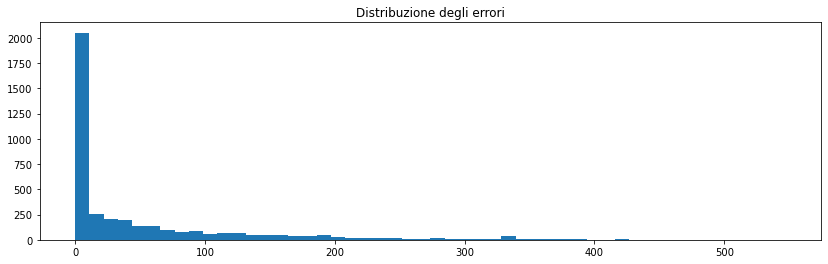

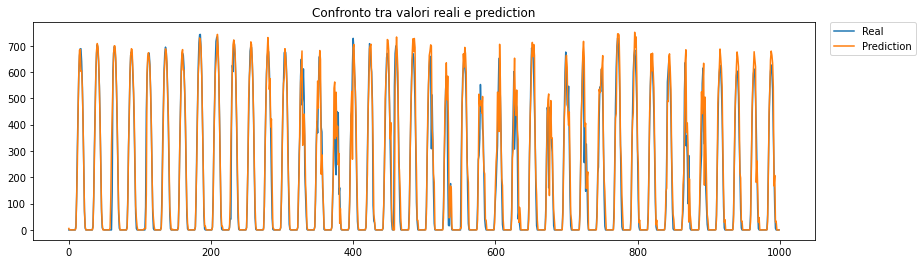

In [ ]:
# Calcola l'errore come scostamento delle predizioni dal valore reale
errors = np.abs(validation_y - validation_y_predicted) 

plt.figure(figsize=(14, 4))
plt.title("Distribuzione degli errori")
plt.hist(x = errors, bins=50)
plt.show()

# Visualizza l'andamento reale e quello predetto
plt.figure(figsize=(14, 4))
plt.title("Confronto tra valori reali e prediction")
plt.plot(validation_y[0:1000], label='Real')
plt.plot(validation_y_predicted[0:1000], label='Prediction')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Predirre la potenza
Si consideri ora lo scenario *predict ahead*, in cui viene richiesto di predire la potenza prodotta dall'impianto fotovoltaico durante l'ora successiva. Identificare il regressore e i relativi iperparametri in grado di ottimizzare l'RMSE sul dataset di test.

Si consideri inoltre che sia [**GridSearchCV(...)**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) che [**cross_val_score(...)**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) utilizzano internamente il meotodo **.score(...)** dell'istanza del regressore per ottenere il punteggio $R^{2}$ relativo alla bontà della regressione. Al fine di utilizzare MSE come punteggio è sufficiente istanziare **GridSearchCV(...)** con il parametro *scoring* impostato al valore *'neg_mean_squared_error'* (stringa). Lo stesso si applica a **cross_val_score(...)**. Per poter ottenere l'RMSE a partire dai punteggi ottenuti durante la *grid search* è sufficiente applicare **np.sqrt(...)** a *-gscv.best\_score\_* e *-gscv.cv\_results\_\['mean_test_score'\]*.

Si inizi valutando quali dati inserire nel dataset (eventualmente ri-eseguendo la fase di caricamento e *preprocessing*) per poi preparare i dati così ottenuti allo scenario *predict ahead*.

Nell'ottimizzazione della soluzione considerare:

- quali feature includere nei pattern
- considerare l'eventuale circolarizzazione delle date (ora del giorno, giorno nell'anno, mese). Vedi: https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
- l'uso di un regressore scelto tra lineare e random forest
- l'eventuale combinazione di due o più regressori
- l'eventuale cleaning dei dati ritenuti anomali

In [ ]:
# Dependecies
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold, cross_val_score
import IPython
import math
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor


# Paths
train_path = './DBs/SolarPark/train.txt'
test_path = './DBs/SolarPark/test.txt'
result_path = 'Es5Predictions.txt'

# Caricamento dei pattern di train
dataframe = pd.read_csv(train_path)

# Date strings to Datetimes.
datetime_strings = dataframe.values[:,1]   
datetimes = [pd.to_datetime(datetime, format='%m/%d/%y %I:%M %p') for datetime in datetime_strings]

time_strings = dataframe.values[:,0] 

# Create new features "month" "day"
ymonth = [datetime.month for datetime in datetimes]  # Meglio usare il mese se split temporale sequenziale
yday = [datetime.timetuple().tm_yday for datetime in datetimes]  # Giorno dell'anno (se split random)

# Cos transformation
yday = pd.DataFrame(yday)
yday_norm = 2 * math.pi * yday / yday.max()
yday_cos = np.cos(yday_norm)
yday_sin = np.sin(yday_norm)

ymonth = pd.DataFrame(ymonth)
ymonth_norm = 2 * math.pi * ymonth / ymonth.max()
ymonth_cos = np.cos(ymonth_norm)
ymonth_sin = np.sin(ymonth_norm)

ytime = pd.DataFrame(time_strings, dtype='int64')
ytime_norm = 2 * math.pi * ytime / ytime.max()
ytime_cos = np.cos(ytime_norm)
ytime_sin = np.sin(ytime_norm)

feature_x = dataframe.values[:,2:6]
feature_x = np.c_[feature_x, ymonth_sin, yday_sin, yday_cos, ytime_cos, ytime_sin]

# Estrae le etichette dal dataframe
feature_y = dataframe.values[:,6]

# Cast di tutti i valori a float32
feature_x = feature_x.astype(np.float32)
feature_y = feature_y.astype(np.float32)

# Slice the feature
data_x = feature_x[0:-1,:]
data_y = feature_y[1:]

# Caricamento dei pattern di test
# Ricordarsi che i valori della colonna 6 (y) non sono disponibili!
test_dataframe = pd.read_csv(test_path)

# Date strings to Datetimes.
datetime_strings = test_dataframe.values[:,1]   
datetimes = [pd.to_datetime(datetime, format='%m/%d/%y %I:%M %p') for datetime in datetime_strings]

time_strings = test_dataframe.values[:,0] 

# Create new features "month" "day"
ymonth = [datetime.month for datetime in datetimes]  # Meglio usare il mese se split temporale sequenziale
yday = [datetime.timetuple().tm_yday for datetime in datetimes]  # Giorno dell'anno (se split random)

# Cos transformation
yday = pd.DataFrame(yday)
yday_norm = 2 * math.pi * yday / yday.max()
yday_cos = np.cos(yday_norm)
yday_sin = np.sin(yday_norm)

ymonth = pd.DataFrame(ymonth)
ymonth_norm = 2 * math.pi * ymonth / ymonth.max()
ymonth_cos = np.cos(ymonth_norm)
ymonth_sin = np.sin(ymonth_norm)

ytime = pd.DataFrame(time_strings, dtype='int64')
ytime_norm = 2 * math.pi * ytime / ytime.max()
ytime_cos = np.cos(ytime_norm)
ytime_sin = np.sin(ytime_norm)

feature_x = test_dataframe.values[:,2:6]
feature_x = np.c_[feature_x, ymonth_sin, yday_sin, yday_cos, ytime_cos, ytime_sin]

# Cast di tutti i valori a float32
feature_x = feature_x.astype(np.float32)

# Creazione e addestramento del classificatore
rf_reg = RandomForestRegressor(n_estimators=230, random_state=1, \
                               max_depth=30, min_samples_leaf=1, min_samples_split=2, n_jobs=-1)

per_mod = Pipeline([
("scaler", StandardScaler()),
("reg", VotingRegressor([
    ('rf', rf_reg)
]))
])

print('Addestramento in corso ...')
reg.fit(data_x, data_y)

# Salvataggio delle predictions
predictions = reg.predict(feature_x)
np.savetxt(result_path, predictions)
print('Ok')

Addestramento in corso ...
Ok


In [ ]:
#################### IMPORTS #######################
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold, cross_val_score
import IPython
import math

#################### LOAD DBs #######################
filePath = './DBs/SolarPark/train.txt'
dataframe = pd.read_csv(filePath)

dataframe["P (kW)"] = dataframe["P (kW)"].shift(-1)
dataframe = dataframe.dropna()

#dataframe = dataframe[~((dataframe["I3 (W/m2)"] == 0.00) & (11 <= dataframe["Time Frame"]) & (dataframe["Time Frame"] <= 16))]
#dataframe = dataframe[~((dataframe["I3 (W/m2)"] != 0.00) & ((dataframe["Time Frame"] <= 4) | (dataframe["Time Frame"] >= 22)))]
#Delete data shit

#index[range(5005,5687)]
#dataframe = dataframe.sort_values(by=['Time Frame'])

#filePath_1 = './DBs/SolarPark/train.txt'
#dataframe_1 = pd.read_csv(filePath_1)

#dataframe_1 = dataframe_1.sort_values(by=['Time Frame'])
#print(pd.DataFrame(dataframe.values[:,2:6], columns=dataframe.columns[2:6]))
#print(pd.DataFrame(dataframe.values[:,1], columns=dataframe.columns[:1]))
#print(dataframe.head())

#X_prova = dataframe.drop(columns=['Time Frame', 'P (kw)'])
#y_prova = dataframe["P (kW)"]

#print(dataframe.describe())

#dataframe.head()
#print()
#print(dataframe.isnull().sum())
#print()

# Visualizzazione grafica della distribuzione dei valori delle features (istogrammi)
#dataframe.hist(bins=50, figsize=(20,15))
#plt.show()

#outliers
#dataframe.boxplot(showmeans=True, figsize=(20,15));

#plt.figure(figsize=(14, 4))
#plt.title("Confronto tra valori reali e prediction")
#plt.plot(dataframe['Time Frame'], dataframe['I3 (W/m2)'], label='Test', )
#plt.plot(dataframe_1['Time Frame'], dataframe_1['I3 (W/m2)'], label='Train')
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
#plt.show()

#index[range(5005,5687)]
#dataframe = dataframe.sort_values(by=['Time Frame'])

#filePath_1 = './DBs/SolarPark/train.txt'
#dataframe_1 = pd.read_csv(filePath_1)

#dataframe_1 = dataframe_1.sort_values(by=['Time Frame'])
#print(pd.DataFrame(dataframe.values[:,2:6], columns=dataframe.columns[2:6]))
#print(pd.DataFrame(dataframe.values[:,1], columns=dataframe.columns[:1]))
#print(dataframe.head())

#X_prova = dataframe.drop(columns=['Time Frame', 'P (kw)'])
#y_prova = dataframe["P (kW)"]

#print(dataframe.describe())

#print(dataframe.shape)
#print()
#print(dataframe.isnull().sum())
#print()

# Visualizzazione grafica della distribuzione dei valori delle features (istogrammi)
#dataframe.hist(bins=50, figsize=(20,15))
#plt.show()

#outliers
#dataframe.boxplot(showmeans=True, figsize=(20,15));

#plt.figure(figsize=(14, 4))
#plt.title("Confronto tra valori reali e prediction")
#plt.plot(dataframe['Time Frame'], dataframe['I3 (W/m2)'], label='Test', )
#plt.plot(dataframe_1['Time Frame'], dataframe_1['I3 (W/m2)'], label='Train')
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
#plt.show()

In [ ]:
#################### PREPROCESSING #######################
# Date strings to Datetimes.
datetime_strings = dataframe.values[:,1]   
datetimes = [pd.to_datetime(datetime, format='%m/%d/%y %I:%M %p') for datetime in datetime_strings]

time_strings = dataframe.values[:,0] 

# Create new features "month" "day"
ymonth = [datetime.month for datetime in datetimes]  # Meglio usare il mese se split temporale sequenziale
yday = [datetime.timetuple().tm_yday for datetime in datetimes]  # Giorno dell'anno (se split random)

# Cos transformation
yday = pd.DataFrame(yday)
yday_norm = 2 * math.pi * yday / yday.max()
yday_cos = np.cos(yday_norm)
yday_sin = np.sin(yday_norm)


ymonth = pd.DataFrame(ymonth)
ymonth_norm = 2 * math.pi * ymonth / ymonth.max()
ymonth_cos = np.cos(ymonth_norm)
ymonth_sin = np.sin(ymonth_norm)

ytime = pd.DataFrame(time_strings, dtype='int64')
ytime_norm = 2 * math.pi * ytime / ytime.max()
ytime_cos = np.cos(ytime_norm)
ytime_sin = np.sin(ytime_norm)

#print(dataframe.head())
#print()
#print(dataframe[2:6])
#print()
#print(dataframe.values[:,2:6])
#print()
#print(dataframe.values[:,6])
#print()
#print(dataframe.values[:,0])

# Choose which features to include
#feature_x = np.c_[feature_x, dataframe.values[:,0]] # Include only Time Frame
#feature_x = np.c_[feature_x, dataframe.values[:,0], month] # Include Time Frame and months
#feature_x = np.c_[feature_x, dataframe.values[:,1], yday_cos, yday_sin, ytime_cos, ytime_sin] # Include Time Frame days
feature_x = dataframe.values[:,2:6]
feature_x = np.c_[feature_x, ymonth_sin, yday_sin, yday_cos, ytime_cos, ytime_sin]

# Estrae le etichette dal dataframe
feature_y = dataframe.values[:,6]

# Cast di tutti i valori a float32
feature_x = feature_x.astype(np.float32)
feature_y = feature_y.astype(np.float32)

# Slice the feature
data_x = feature_x
data_y = feature_y


In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# identify outliers in the training dataset
lof = LocalOutlierFactor()
yhat = lof.fit_predict(data_x)


# select all rows that are not outliers
mask = yhat != -1
data_x, data_y = data_x[mask, :], data_y[mask]

In [ ]:
valid_portion = 1/3
split_random = True

if split_random:
    # Split casuale di train e validation set
    train_x, validation_x, train_y, validation_y = train_test_split(data_x, data_y, test_size=valid_portion, random_state=1)
else:    
    # Split temporale
    train_x, validation_x, train_y, validation_y = train_test_split(data_x, data_y, test_size=valid_portion, shuffle=False)

In [ ]:
# Ottimizzazione con Cross-Validation
rf_reg = RandomForestRegressor()
ln_reg = LinearRegression()

params = [{
 'max_depth': [10,15,25,30,35],
 'min_samples_split': [2,3,4],
 'n_estimators': [200,220,240,280],
 'n_jobs':[-1],
 'random_state':[42,1]
}]

gscv = GridSearchCV(
    rf_reg,
    params,
    cv=KFold(n_splits=4, shuffle=False),
    verbose=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

results = gscv.fit(train_x, train_y)

# Print results
print('RMSE medio per combinazione:\n', np.sqrt(-gscv.cv_results_['mean_test_score']))
print(results.best_estimator_)
print(results.best_params_)

# Bip
IPython.display.Audio("prova.mp3", autoplay=True)

Fitting 4 folds for each of 120 candidates, totalling 480 fits
RMSE medio per combinazione:
 [67.87795614 67.74065316 67.88979188 67.84431369 67.94606154 67.81986052
 67.90317455 67.80338925 67.98691184 67.67605441 67.95651355 67.76259943
 67.99274855 67.78047265 67.94899232 67.82318852 68.08529719 67.76959252
 68.09459914 67.85499933 68.12138171 67.86888244 68.07473314 67.91238039
 67.72717726 67.36180836 67.71311009 67.45680229 67.77899862 67.47762955
 67.70504767 67.48596048 67.68307182 67.34824064 67.67117387 67.4240957
 67.73021353 67.43272004 67.68385899 67.46081558 67.8392399  67.59062542
 67.84017804 67.67474252 67.86174363 67.66311949 67.84689474 67.65552064
 67.57954313 67.26427431 67.57141923 67.34779919 67.63205136 67.32147609
 67.5872963  67.32935886 67.76170922 67.3720274  67.72915084 67.4445785
 67.76244242 67.44453066 67.76627163 67.43733784 67.76188836 67.49876398
 67.76976182 67.56984001 67.79446463 67.5614085  67.75989216 67.59396923
 67.58095269 67.28134646 67.58277

VAL: 58.94840852361439


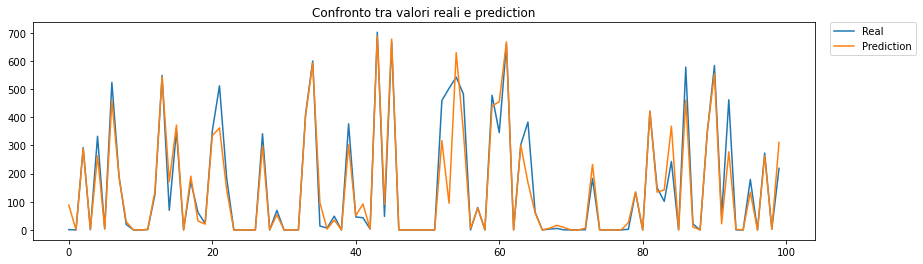

In [ ]:
rf_reg = RandomForestRegressor(n_estimators=230, random_state=1, \
                               max_depth=30, min_samples_leaf=1, min_samples_split=2, n_jobs=-1)

per_mod = Pipeline([
("scaler", StandardScaler()),
("reg", VotingRegressor([
    ('rf', rf_reg)
]))
])

per_mod.fit(train_x, train_y)
predictions = per_mod.predict(validation_x)
print("VAL: " + str(math.sqrt(mean_squared_error(validation_y, predictions))))

plt.figure(figsize=(14, 4))
plt.title("Confronto tra valori reali e prediction")
plt.plot(validation_y[:100], label='Real')
plt.plot(predictions[:100], label='Prediction')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Test eventuali

Codice usato per testare e trovare la migliore soluzione.

In [ ]:
# Date strings to Datetimes.
datetime_strings = dataframe.values[:,1]   
datetimes = [pd.to_datetime(datetime, format='%m/%d/%y %I:%M %p') for datetime in datetime_strings]

time_strings = dataframe.values[:,0] 

# Create new features "month" "day"
ymonth = [datetime.month for datetime in datetimes]  # Meglio usare il mese se split temporale sequenziale
yday = [datetime.timetuple().tm_yday for datetime in datetimes]  # Giorno dell'anno (se split random)

# Cos transformation
yday = pd.DataFrame(yday)
yday_norm = 2 * math.pi * yday / yday.max()
yday_cos = np.cos(yday_norm)
ytime = pd.DataFrame(time_strings, dtype='int64')
ytime_norm = 2 * math.pi * ytime / ytime.max()
ytime_cos = np.cos(ytime_norm)
ymonth = pd.DataFrame(ymonth)
ymonth_norm = 2 * math.pi * ymonth / ymonth.max()
ymonth_cos = np.cos(ymonth_norm)

dataframe = dataframe.drop(columns=['Time Frame'])
print(dataframe.head())

feature_x = dataframe.values[:,1:5]
#print(feature_x)

feature_x = np.c_[feature_x, yday_cos, ytime_cos] # Include Time Frame days
print(feature_x)

feature_y = dataframe.values[:,5]
print(feature_y)

feature_x = feature_x.astype(np.float32)
feature_y = feature_y.astype(np.float32)

# Slice the feature to predict ahead
data_x = feature_x[0:-1,:]
data_y = feature_y[1:]

In [ ]:
Q1 = dataframe.quantile(0.25)
Q3 = dataframe.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

print(dataframe["I3 (W/m2)"].quantile(0.5))
print(dataframe["I3 (W/m2)"].quantile(0.95))
print(dataframe["I3 (W/m2)"].quantile(0.75))

dataframe["I3 (W/m2)"] = np.where(dataframe["I3 (W/m2)"] > 855.97, 364.79, dataframe["I3 (W/m2)"])

dataframe.hist(bins=50, figsize=(20,15))

#----------------------------

#q_low = dataframe["I3 (W/m2)"].quantile(0.01)
#q_high = dataframe["I3 (W/m2)"].quantile(0.99)

#dataframe = dataframe[(dataframe["I3 (W/m2)"] < q_high) & (dataframe["I3 (W/m2)"] > q_low)]

print(dataframe.shape)

dataframe.hist(bins=50, figsize=(20,15))
plt.show()

#outliers
dataframe.boxplot(showmeans=True, figsize=(20,15));

In [ ]:
# calculate summary statistics
data_mean, data_std = dataframe["Ta (C)"].mean(), dataframe["Ta (C)"].std()

# identify outliers
cut_off = data_std * 2
lower, upper = data_mean - cut_off, data_mean + cut_off

# identify outliers
outliers = [x for x in dataframe["Ta (C)"] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

outliers_removed = [x for x in dataframe["Ta (C)"] if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

dataframe = dataframe[(dataframe["Ta (C)"] <= upper) & (dataframe["Ta (C)"] >= lower)]

print(dataframe.shape)

##################################################################
# calculate summary statistics
data_mean, data_std = dataframe["Tm (C)"].mean(), dataframe["Tm (C)"].std()

# identify outliers
cut_off = data_std * 2
lower, upper = data_mean - cut_off, data_mean + cut_off

# identify outliers
outliers = [x for x in dataframe["Tm (C)"] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

outliers_removed = [x for x in dataframe["Tm (C)"] if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

dataframe = dataframe[(dataframe["Tm (C)"] <= upper) & (dataframe["Tm (C)"] >= lower)]

print(dataframe.shape)

##################################################################
# calculate summary statistics
data_mean, data_std = dataframe["I3 (W/m2)"].mean(), dataframe["I3 (W/m2)"].std()

# identify outliers
cut_off = data_std * 2
lower, upper = data_mean - cut_off, data_mean + cut_off

# identify outliers
outliers = [x for x in dataframe["I3 (W/m2)"] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

outliers_removed = [x for x in dataframe["I3 (W/m2)"] if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

dataframe = dataframe[(dataframe["I3 (W/m2)"] <= upper) & (dataframe["I3 (W/m2)"] >= lower)]

print(dataframe.shape)

##################################################################
# calculate summary statistics
data_mean, data_std = dataframe["I15 (W/m2)"].mean(), dataframe["I15 (W/m2)"].std()

# identify outliers
cut_off = data_std * 2
lower, upper = data_mean - cut_off, data_mean + cut_off

# identify outliers
outliers = [x for x in dataframe["I15 (W/m2)"] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

outliers_removed = [x for x in dataframe["I15 (W/m2)"] if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

dataframe = dataframe[(dataframe["I15 (W/m2)"] <= upper) & (dataframe["I15 (W/m2)"] >= lower)]

print(dataframe.shape)

In [ ]:
# Ottimizzazione con Cross-Validation
rf_reg = RandomForestRegressor()
ln_reg = LinearRegression()

params = [{
 'max_depth': [40, 50, 55 ],
 'min_samples_leaf': [3, 4, 5],
 'min_samples_split': [ 8, 10, 12],
 'n_estimators': [200, 220, 240],
 'n_jobs':[-1],
 'random_state':[42,1]
}]

gscv = GridSearchCV(
    rf_reg,
    params,
    cv=KFold(n_splits=5, shuffle=False),
    verbose=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

results = gscv.fit(data_x, data_y)

# Print results
print('RMSE medio per combinazione:\n', np.sqrt(-gscv.cv_results_['mean_test_score']))
print(results.best_estimator_)
print(results.best_params_)

# Bip
IPython.display.Audio("prova.mp3", autoplay=True)

In [ ]:
# Ottimizzazione con Cross-Validation
rf_reg = RandomForestRegressor()
ln_reg = Lasso()

params = [{
 'alpha': [0.00001, 0.0001,0.002, 0.001,0.01,0.1,1],
 'normalize': [True, False],
 'random_state':[42,1]
}]

gscv = GridSearchCV(
    ln_reg,
    params,
    cv=KFold(n_splits=5, shuffle=False),
    verbose=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

results = gscv.fit(data_x, data_y)

# Print results
print('RMSE medio per combinazione:\n', np.sqrt(-gscv.cv_results_['mean_test_score']))
print(results.best_estimator_)
print(results.best_params_)

# Bip
#IPython.display.Audio("prova.mp3", autoplay=True)

In [ ]:
np.warnings.filterwarnings('ignore') 
# Verifica dei parametri trovati
tscv = TimeSeriesSplit(n_splits=5, test_size=500)
# Results
rmse_val = []
rmse_train = []


for train_index, val_index in tscv.split(data_x):
    X_train, X_val = data_x[train_index], data_x[val_index]
    y_train, y_val = data_y[train_index], data_y[val_index]
    
    print(X_train.shape)
    print(X_val.shape)
    print(y_train.shape)
    print(y_val.shape)
    
    rf_reg = RandomForestRegressor(n_estimators=200, random_state=1, \
                                   max_depth=40, min_samples_leaf=5, min_samples_split=12, n_jobs=-1)
    ln_reg = LinearRegression(n_jobs=-1, fit_intercept=True, normalize=True)
    
    
    per_mod = Pipeline([
    #("scaler", StandardScaler()),
    ("reg", VotingRegressor([
        #('lr', ln_reg),
        ('rf', rf_reg)
    ]))
    ])
    
    per_mod.fit(X_train, y_train)
    predictions = per_mod.predict(X_val)
    print("VAL: " + str(math.sqrt(mean_squared_error(y_val, predictions))))
    rmse_val.append(math.sqrt(mean_squared_error(y_val, predictions)))
    
    predictions_train = per_mod.predict(X_train)
    print(math.sqrt(mean_squared_error(y_train, predictions_train)))
    rmse_train.append(math.sqrt(mean_squared_error(y_train, predictions_train)))
    
    
    
    
    plt.figure(figsize=(14, 4))
    plt.title("Confronto tra valori reali e prediction")
    plt.plot(y_val[:], label='Real')
    plt.plot(predictions[:], label='Prediction')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
    plt.show()
    
print("RMSE VAL: {}".format(np.mean(rmse_val)))
print("RMSE : {}".format(np.mean(rmse_train)))
